# PROJECT STOCK PRICE PREDICTION (IBM STOCK PRICE)
ROMIT RAJ  
2011MT16  
MTECH MECHATRONICS


Importing libraries

In [ ]:
#!pip install pmdarima

In [ ]:
#import packages
import pandas as pd
import numpy as np
from numpy import array
from pandas_datareader import data as pdr
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

Loading dataset

In [ ]:
ibm = pdr.DataReader('IBM', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))
ibm.to_csv('IBM_stock.csv', sep=',')
ibm = ibm.reset_index()

In [ ]:
ibm.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-08-01,191.500000,188.860001,190.500000,189.149994,5181100.0,143.561371
1,2014-08-04,189.949997,188.600006,189.350006,189.639999,2125900.0,143.933304
2,2014-08-05,189.199997,186.440002,188.750000,187.100006,3307900.0,142.005493
3,2014-08-06,186.880005,184.440002,185.360001,185.970001,3847000.0,141.982544
4,2014-08-07,186.679993,183.580002,186.639999,184.300003,2708600.0,140.707535


Visualizing data

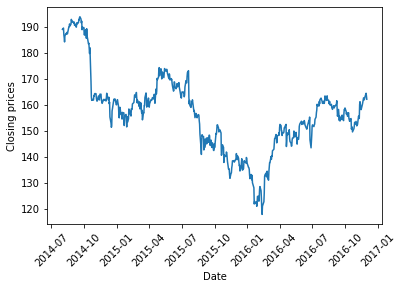

In [ ]:
plt.plot(ibm["Date"],ibm["Close"])
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.show()

<Figure size 432x288 with 0 Axes>

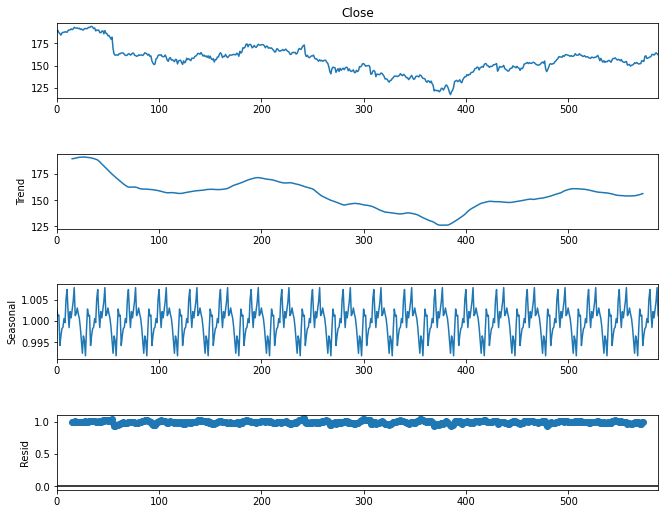

In [ ]:
result = seasonal_decompose(ibm["Close"], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 8)

checks for Stationarity

In [ ]:
def adf_test(atr):
  timeseries = ibm[atr].dropna()
  print ('Results of Dickey-Fuller Test for ',atr,'\n')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

adf_test('Close')

Results of Dickey-Fuller Test for  Close 

Test Statistic                  -2.279273
p-value                          0.178740
#Lags Used                       0.000000
Number of Observations Used    588.000000
Critical Value (1%)             -3.441520
Critical Value (5%)             -2.866468
Critical Value (10%)            -2.569394
dtype: float64


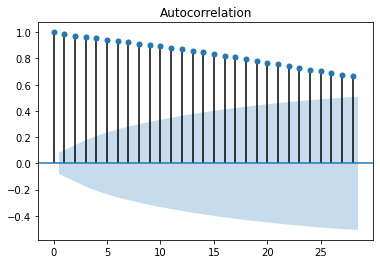

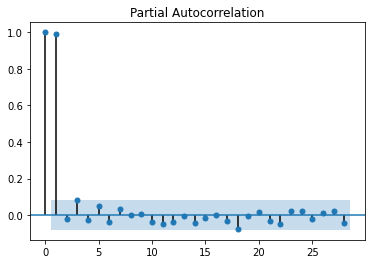

In [ ]:
# plot acf and pacf graph
plot_acf(ibm['Close'])
plot_pacf(ibm['Close'])
plt.show()

From ADF TEST, p value is more than 0.05 so the data is NON STATIONARY.

and also from acf and pacf plot we can see non stationarity in data.

Convert into stationary with 1st differencing

In [ ]:
ibm['diff'] = ibm['Close'].diff(periods=1)

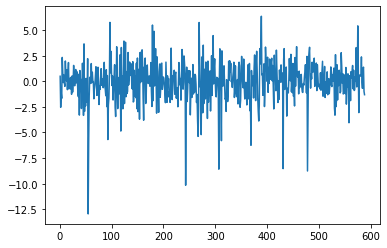

In [ ]:
ibm["diff"].plot()

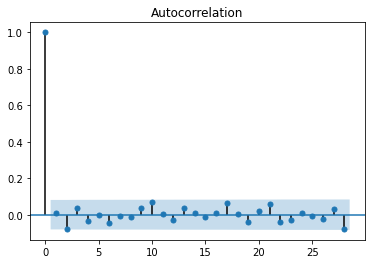

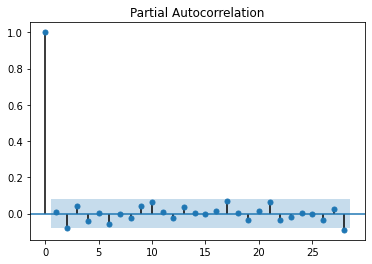

In [ ]:
plot_acf(ibm['diff'].dropna())
plot_pacf(ibm['diff'].dropna())
plt.show()

from ACF and PACF plots sationarity can be noticed as all the lags aprroximately within confidence level.

Preparing data

In [ ]:
n = int(len(ibm["Close"])*0.8)
train = ibm.Close[:n]
test = ibm.Close[n:]

### MODEL 1: DOUBLE EXPONENTIAL SMOOTHING

In [ ]:
model = ExponentialSmoothing(test,trend='mul',seasonal='mul',seasonal_periods=12)
yhat = model.fit(smoothing_level = 0.9,smoothing_slope= 0.1,smoothing_seasonal = 0.2).fittedvalues.shift(0)
RMSE = sqrt(mean_squared_error(test, yhat))
print("RMSE with triple exponential smoothing :",RMSE)

RMSE with triple exponential smoothing : 1.7982013245603996


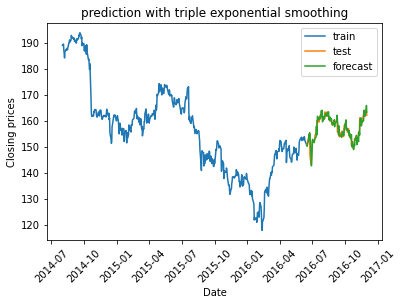

In [ ]:
plt.title("prediction with triple exponential smoothing")
plt.plot(ibm.Date[:n],train,label = "train")
plt.plot(ibm.Date[n:],test,label = "test")
plt.plot(ibm.Date[n:],yhat,label = "forecast")
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.legend()

### MODEL 2: ARIMA

In [ ]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ibm["Close"], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2471.231, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2473.595, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2475.556, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2475.548, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2471.911, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2472.974, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2472.874, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2473.290, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2473.745, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2474.239, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2469.536, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2473.858, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2473.866, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2471.303, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [ ]:
# fit model
model = ARIMA(ibm["Close"], order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(train), len(train)+len(test)-1)
RMSE = sqrt(mean_squared_error(test, yhat))
print("RMSE with ARIMA(1,1,1) :",RMSE)

RMSE with ARIMA(1,1,1) : 1.6546135273567522


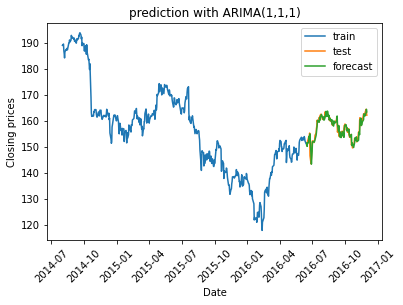

In [ ]:
plt.title("prediction with ARIMA(1,1,1)")
plt.plot(ibm.Date[:n],train,label = "train")
plt.plot(ibm.Date[n:],test,label = "test")
plt.plot(ibm.Date[n:],yhat,label = "forecast")
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.legend()

### MODEL 3: LSTM

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
raw_seq = ibm['Close']
trainLen = n
train = raw_seq[:trainLen]
test = raw_seq[trainLen:]

In [ ]:
n_steps = 3
n_features = 1
X, y = split_sequence(train, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
history = model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 3ms/step - loss: 17467.6910
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 10627.1175
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 5144.6352
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 77.9131
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 55.8790
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 12.7906
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 8.0984
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 8.7022
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 6.9791
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 7.8388
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 7.5095
Epoch 12/100
15/15 [==============================] - 0s 3ms/step - loss: 8.3523
Epoch 13/100
15/15 [===

In [ ]:
test = test.reset_index(drop = True)

In [ ]:
# demonstrate prediction
X_test, y_test = split_sequence(test, n_steps)
X_test = np.array(X_test).reshape((-1, n_steps, n_features))
pred = model.predict(X_test, verbose=0)
yhat = pd.DataFrame(pred,ibm.Date[n+3:])

In [ ]:
RMSE = sqrt(mean_squared_error(y_test, pred))
print("RMSE with LSTM :",RMSE)

RMSE with LSTM : 1.709663387136825


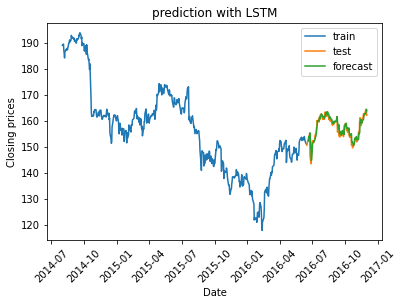

In [ ]:
plt.title("prediction with LSTM")
plt.plot(ibm.Date[:n],train,label = "train")
plt.plot(ibm.Date[n:],test,label = "test")
plt.plot(yhat,label = "forecast")
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.xticks(rotation=45)
plt.legend()

### CONCLUSION
RMSE with ARIMA(1,1,1) : 1.654 

RMSE with triple exponential smoothing : 1.798 

RMSE with LSTM : 1.709

So ARIMA(1,1,1) models predicts better than other too models.
